# import library

In [1]:
import numpy as np
import matplotlib.pylab as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from underthesea import word_tokenize
from stop_words import get_stop_words
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Bidirectional, LSTM

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re


# Data processing

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from underthesea import word_tokenize
from stop_words import get_stop_words
from gensim.models import Word2Vec

import re

def processingViEn(text):
    # chuyển về chữ thường
    text = text.strip().lower()
    # Loại bỏ số
    # text = re.sub(r'\d+', '', text)
    # Loại bỏ các ký tự không cần thiết (trong ví dụ này, loại bỏ dấu chấm, dấu phẩy và dấu hỏi)
    text = re.sub(r'[.,?!()|"\'\-:;]', ' ', text)

    # Loại bỏ các khoảng trắng dư thừa (nhiều hơn 2)
    text = re.sub(r'\s{2,}', ' ', text)
    return text



# Load data

In [3]:
data = []
label = []
with open('./sentiment.txt') as doc:
    for d in doc:
        line = d.strip().split('\t')
        data.append(line[0].lower())
        label.append(int(line[1]))

# Using padding

In [83]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
X = pad_sequences(sequences)
y = np.array(label)

In [84]:
vocab_size = len(tokenizer.word_index)
vocab_size

2071

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [109]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [110]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 32), (700, 1), (300, 32), (300, 1))

In [123]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1]),
    Bidirectional(LSTM(32, dropout = 0.2, return_sequences=True)),
    Bidirectional(LSTM(16, return_sequences=True)),
    # Flatten(),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
22/22 [==============================] - 12s 254ms/step - loss: 0.8806 - accuracy: 0.5225 - val_loss: 0.8606 - val_accuracy: 0.5267
Epoch 2/50
22/22 [==============================] - 3s 120ms/step - loss: 0.8277 - accuracy: 0.6673 - val_loss: 0.7820 - val_accuracy: 0.7175
Epoch 3/50
22/22 [==============================] - 3s 129ms/step - loss: 0.5966 - accuracy: 0.8684 - val_loss: 0.7147 - val_accuracy: 0.7444
Epoch 4/50
22/22 [==============================] - 3s 123ms/step - loss: 0.3895 - accuracy: 0.9253 - val_loss: 0.6953 - val_accuracy: 0.7678
Epoch 5/50
22/22 [==============================] - 1s 62ms/step - loss: 0.2793 - accuracy: 0.9583 - val_loss: 0.7678 - val_accuracy: 0.7724
Epoch 6/50
22/22 [==============================] - 2s 73ms/step - loss: 0.2044 - accuracy: 0.9786 - val_loss: 0.8664 - val_accuracy: 0.7608
Epoch 7/50
22/22 [==============================] - 2s 99ms/step - loss: 0.1639 - accuracy: 0.9857 - val_loss: 0.9305 - val_accuracy: 0.7507
Epoch 8/

In [89]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           207100    
                                                                 
 dense (Dense)               (None, 32, 64)            6464      
                                                                 
 dense_1 (Dense)             (None, 32, 1)             65        
                                                                 
Total params: 213,629
Trainable params: 213,629
Non-trainable params: 0
_________________________________________________________________


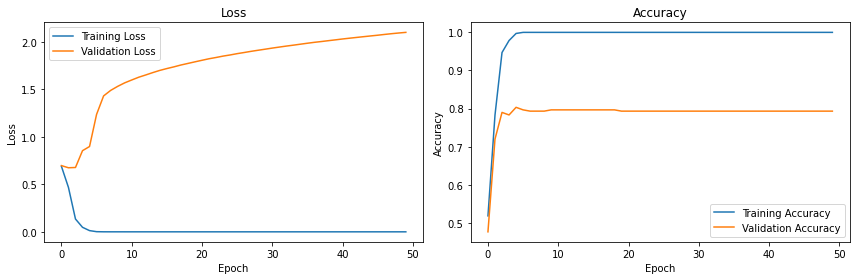

In [98]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Vẽ đồ thị loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [124]:
# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Độ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")

10/10 [==============================] - 0s 6ms/step - loss: 1.3666 - accuracy: 0.7295
Độ chính xác trên tập kiểm tra: 72.95%


# Word2Vec

In [4]:
# train
from gensim.models import Word2Vec

In [14]:
documents = [processingViEn(word) for word in data]
# tokenization
processed_documents = []
# stop_words = get_stop_words('vi')
stop_words = set(stopwords.words('english'))
for idx, document in enumerate(documents):
    print(f'document {idx + 1}')
    token = word_tokenize(document)
    rm_stopword = [word for word in token if word not in stop_words]
    processed_documents.append(rm_stopword)

document 1
document 2
document 3
document 4
document 5
document 6
document 7
document 8
document 9
document 10
document 11
document 12
document 13
document 14
document 15
document 16
document 17
document 18
document 19
document 20
document 21
document 22
document 23
document 24
document 25
document 26
document 27
document 28
document 29
document 30
document 31
document 32
document 33
document 34
document 35
document 36
document 37
document 38
document 39
document 40
document 41
document 42
document 43
document 44
document 45
document 46
document 47
document 48
document 49
document 50
document 51
document 52
document 53
document 54
document 55
document 56
document 57
document 58
document 59
document 60
document 61
document 62
document 63
document 64
document 65
document 66
document 67
document 68
document 69
document 70
document 71
document 72
document 73
document 74
document 75
document 76
document 77
document 78
document 79
document 80
document 81
document 82
document 83
document 84
d

In [15]:
model = Word2Vec(processed_documents, vector_size=100, window=5, min_count=1, sg=1)
# Lưu mô hình
model.save("word2vec_classifi.model")

In [43]:
# Moad model
word2vec_model = Word2Vec.load('./word2vec_classifi.model')

In [71]:
# Để biểu diễn một câu hoặc văn bản bằng Word2Vec, có thể tính trung bình hoặc tối đa của các vectơ từ trong câu

def document_to_vector(document, word2vec_model):
    # Tách câu thành các từ hoặc token
    tokens = document
    # print(tokens)
    
    # Khởi tạo một vectơ con số học
    doc_vector = np.zeros(word2vec_model.vector_size)
    
    # Đếm số từ trong câu
    num_words = 0
    
    for token in tokens:
        if token in word2vec_model.wv:
            doc_vector += word2vec_model.wv[token]
            num_words += 1
    
    if num_words > 0:
        doc_vector /= num_words
    
    return doc_vector

# Biểu diễn dữ liệu dưới dạng vectơ
matrix_w2v = [document_to_vector(doc, word2vec_model) for doc in processed_documents]


In [72]:
X = np.array(matrix_w2v)
y = np.array(label)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [74]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [84]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((700, 100), (700, 1), (300, 100), (300, 1))

In [87]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    # Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1]),
    # Bidirectional(LSTM(32, dropout = 0.2, return_sequences=True)),
    # Bidirectional(LSTM(16, return_sequences=True)),
    # Flatten(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
44/44 [==============================] - 1s 6ms/step - loss: 1.2634 - accuracy: 0.4914 - val_loss: 1.0712 - val_accuracy: 0.4767
Epoch 2/50
44/44 [==============================] - 0s 5ms/step - loss: 0.9559 - accuracy: 0.5100 - val_loss: 0.8610 - val_accuracy: 0.4767
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8064 - accuracy: 0.5100 - val_loss: 0.7638 - val_accuracy: 0.4767
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7390 - accuracy: 0.5100 - val_loss: 0.7207 - val_accuracy: 0.4767
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7100 - accuracy: 0.5100 - val_loss: 0.7038 - val_accuracy: 0.4767
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5100 - val_loss: 0.6969 - val_accuracy: 0.4767
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5100 - val_loss: 0.6954 - val_accuracy: 0.4767
Epoch 8/50
44/44 [==

# TI-IDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [76]:
documents = [processingViEn(word) for word in data]
# tokenization
processed_documents = []
stop_words = get_stop_words('vi')
for idx, document in enumerate(documents):
    print(f'document {idx + 1}')
    token = word_tokenize(document)
    rm_stopword = [word for word in token if word not in stop_words]
    processed_documents.append(rm_stopword)

document 1
document 2
document 3
document 4
document 5
document 6
document 7
document 8
document 9
document 10
document 11
document 12
document 13
document 14
document 15
document 16
document 17
document 18
document 19
document 20
document 21
document 22
document 23
document 24
document 25
document 26
document 27
document 28
document 29
document 30
document 31
document 32
document 33
document 34
document 35
document 36
document 37
document 38
document 39
document 40
document 41
document 42
document 43
document 44
document 45
document 46
document 47
document 48
document 49
document 50
document 51
document 52
document 53
document 54
document 55
document 56
document 57
document 58
document 59
document 60
document 61
document 62
document 63
document 64
document 65
document 66
document 67
document 68
document 69
document 70
document 71
document 72
document 73
document 74
document 75
document 76
document 77
document 78
document 79
document 80
document 81
document 82
document 83
document 84
d

In [82]:
documents

['wow loved this place ',
 'crust is not good ',
 'not tasty and the texture was just nasty ',
 'stopped by during the late may bank holiday off rick steve recommendation and loved it ',
 'the selection on the menu was great and so were the prices ',
 'now i am getting angry and i want my damn pho ',
 'honeslty it didn t taste that fresh ',
 'the potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer ',
 'the fries were great too ',
 'a great touch ',
 'service was very prompt ',
 'would not go back ',
 'the cashier had no care what so ever on what i had to say it still ended up being wayyy overpriced ',
 'i tried the cape cod ravoli chicken with cranberry mmmm ',
 'i was disgusted because i was pretty sure that was human hair ',
 'i was shocked because no signs indicate cash only ',
 'highly recommended ',
 'waitress was a little slow in service ',
 'this place is not worth your time let alone vegas ',
 'did not like at all ',
 'the 

In [83]:
# Tạo một đối tượng TfidfVectorizer
tfidf = TfidfVectorizer()

# Biến đổi dữ liệu văn bản thành ma trận TF-IDF

# Kết hợp danh sách các từ thành các chuỗi cho mỗi văn bản
# processed_documents_as_strings = [' '.join(document) for document in processed_documents]

tfidf_matrix = tfidf.fit_transform(documents)
tfidf_matrix = tfidf_matrix.toarray()

In [80]:
len(tfidf.vocabulary_)

2035

In [81]:
tfidf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
X = tfidf_matrix
y = np.array(label)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 2030), (700, 1), (300, 2030), (300, 1))

In [37]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    # Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1]),
    # Bidirectional(LSTM(32, dropout = 0.2, return_sequences=True)),
    # Bidirectional(LSTM(16, return_sequences=True)),
    # Flatten(),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
88/88 [==============================] - 15s 131ms/step - loss: 0.9589 - accuracy: 0.4734 - val_loss: 0.8333 - val_accuracy: 0.5233
Epoch 2/50
88/88 [==============================] - 10s 116ms/step - loss: 0.7745 - accuracy: 0.4907 - val_loss: 0.7328 - val_accuracy: 0.4767
Epoch 3/50
88/88 [==============================] - 10s 118ms/step - loss: 0.7144 - accuracy: 0.5100 - val_loss: 0.7028 - val_accuracy: 0.4767
Epoch 4/50
88/88 [==============================] - 10s 116ms/step - loss: 0.6978 - accuracy: 0.5100 - val_loss: 0.6953 - val_accuracy: 0.4767
Epoch 5/50
88/88 [==============================] - 10s 117ms/step - loss: 0.6940 - accuracy: 0.5100 - val_loss: 0.6940 - val_accuracy: 0.4767
Epoch 6/50
88/88 [==============================] - 10s 117ms/step - loss: 0.6932 - accuracy: 0.5100 - val_loss: 0.6938 - val_accuracy: 0.4767
Epoch 7/50
88/88 [==============================] - 10s 118ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6938 - val_accuracy: 0.4767

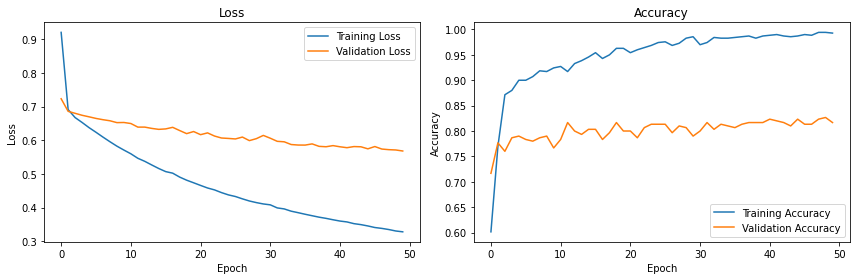

In [36]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Vẽ đồ thị loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()